
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit 
from teslakit.alr import ALR_WRP
from teslakit.util.time_operations import xds_reindex_daily, xds_common_dates_daily

from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.waves import Plot_Waves_DWTs

from teslakit.io.aux_nc import StoreBugXdset



## Database and Site parameters

In [2]:
# Teslakit database

site ='ROI'
p_data = r'/Users/albacid/Projects/TeslaKit_projects/sites/' + site + '/'

p_outputs = p_data + 'ClimateChange/'



In [3]:
# --------------------------------------
# load data and set parameters

KMA_fit = xr.open_dataset(p_data + '/ESTELA/pred_SLP/kma.nc') # Historical bmus. ESTELA + TCs Predictor (daily)
MJO_sim_all = xr.open_dataset(p_data + '/MJO/MJO_sim.nc')        # MJO simulation (daily)
PCs_sim_all = xr.open_dataset(p_outputs + '/CC_SST_PCs_sim_d.nc')     # SST PCs simulation (daily)

# ALR fit parameters
alr_num_clusters = 42
alr_markov_order = 1
alr_seasonality = [2, 4]

# ALR simulation
num_sims = 10 # one simulation for each simulated MJO, SST 


In [5]:
# --------------------------------------
# Data used to FIT ALR model and preprocess: 

# KMA: bmus (daily) (use sorted_bmus_storms, add 1 to get 1-42 bmus set)
BMUS_fit = xr.Dataset(
    {
        'bmus':(('time',), KMA_fit['sorted_bmus_storms'].values[:] + 1),
    },
    coords = {'time': KMA_fit.time.values[:]}
)




## ESTELA Predictor - Autoregressive Logistic Regression Simulation

In [8]:
# --------------------------------------
# Prepare Covariates for ALR simulations

# simulation dates
d_sim = xds_common_dates_daily([MJO_sim_all, PCs_sim_all])

# join covariates for all MJO, PCs simulations
l_cov_sims = []
for i in MJO_sim_all.n_sim: 

    # select simulation
    MJO_sim = MJO_sim_all.sel(n_sim=i)
    PCs_sim = PCs_sim_all.sel(n_sim=i)

    # PCs covar 
    cov_PCs = PCs_sim.sel(time = slice(d_sim[0], d_sim[-1]))
    cov_1 = cov_PCs.PC1.values.reshape(-1,1)
    cov_2 = cov_PCs.PC2.values.reshape(-1,1)
    cov_3 = cov_PCs.PC3.values.reshape(-1,1)

    # MJO covars
    cov_MJO = MJO_sim.sel(time = slice(d_sim[0], d_sim[-1]))
    cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
    cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

    # join covars (do not normalize simulation covariates)
    cov_T_sim = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))
    cov_sim = xr.Dataset(
        {
            'cov_values': (('time','n_covariates'), cov_T_sim),
            'cov_names': (('n_covariates',), ['PC1','PC2','PC3','MJO1','MJO2']),
        },
        coords = {'time': d_sim}
    )
    l_cov_sims.append(cov_sim)

# use "n_sim" name to join covariates (ALR.Simulate() will recognize it)
cov_sims = xr.concat(l_cov_sims, dim='n_sim')
cov_sims = cov_sims.squeeze()

print(cov_sims)


<xarray.Dataset>
Dimensions:     (n_covariates: 5, time: 365243)
Coordinates:
  * time        (time) object 1700-01-01 1700-01-02 ... 2699-12-31 2700-01-01
Dimensions without coordinates: n_covariates
Data variables:
    cov_values  (time, n_covariates) float32 61.475624 -17.110228 ... 0.74786484
    cov_names   (n_covariates) <U4 'PC1' 'PC2' 'PC3' 'MJO1' 'MJO2'


In [9]:
# --------------------------------------
# Autoregressive Logistic Regression

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'long_term' : False,
    'seasonality': (True, alr_seasonality),
    'covariates': (True, cov_sim),  # Ojo: he cambiado cov_fit por cov_sim porque creo que de aquí solo utiliza 
                                    # cov_names, no los valores. También he añadido cov_names, que antes no se guardaba     
}


# ALR wrapper
model_fit = p_data + 'ESTELA/alr_w/'
ALRW = ALR_WRP(model_fit)
ALRW.SetFitData(alr_num_clusters, BMUS_fit, d_terms_settings)

ALRW.LoadModel()

In [10]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# launch simulation
xds_alr = ALRW.Simulate(num_sims, d_sim, cov_sims)

# Store Daily Weather Types
DWT_sim = xds_alr.evbmus_sims.to_dataset()
StoreBugXdset(DWT_sim, p_outputs + 'CC_DWT_sim.nc')

print(DWT_sim)


ALR model fit   : 1979-02-12 --- 2011-03-31
ALR model sim   : 1700-01-01 --- 2700-01-01

Launching 10 simulations...

Sim. Num. 010: 100%|██████████| 365242/365242 [08:41<00:00, 700.29it/s]

<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 365243)
Coordinates:
  * time         (time) object 1700-01-01 1700-01-02 ... 2699-12-31 2700-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 18 18 18 18 18 18 18 ... 30 33 33 26 33 30


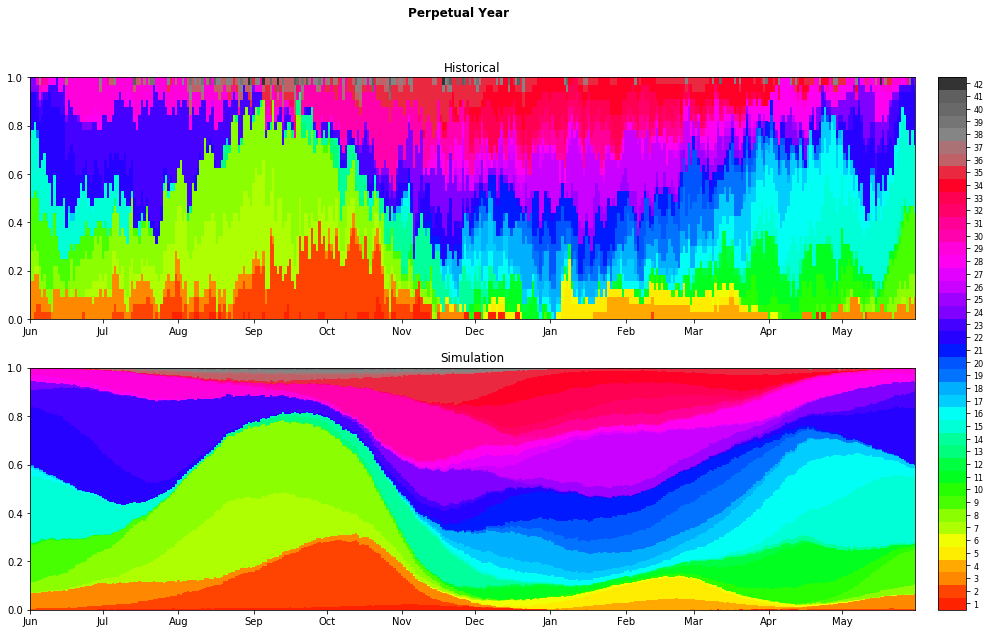

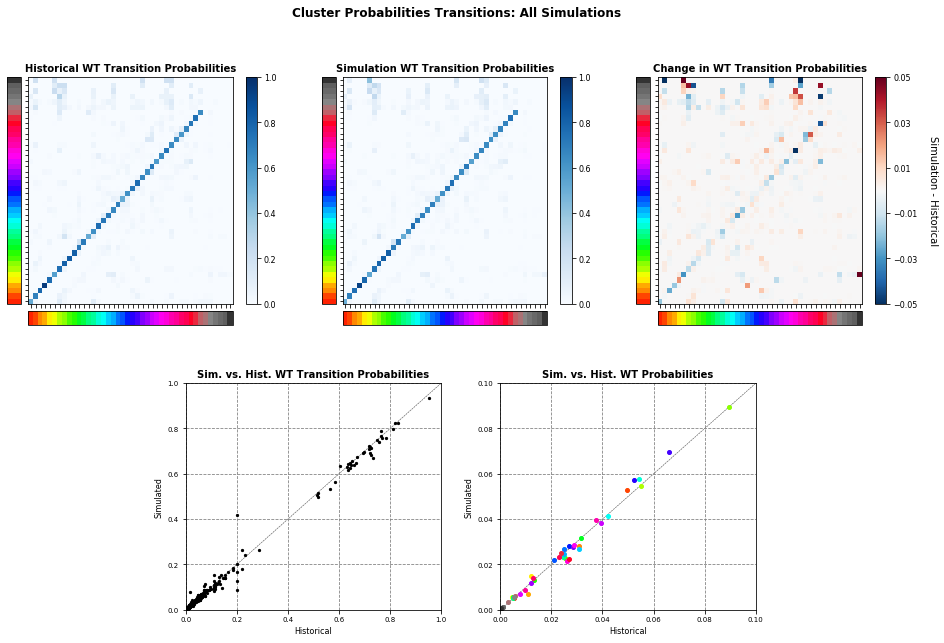

In [11]:
# show sim report
ALRW.Report_Sim(py_month_ini=6);
 

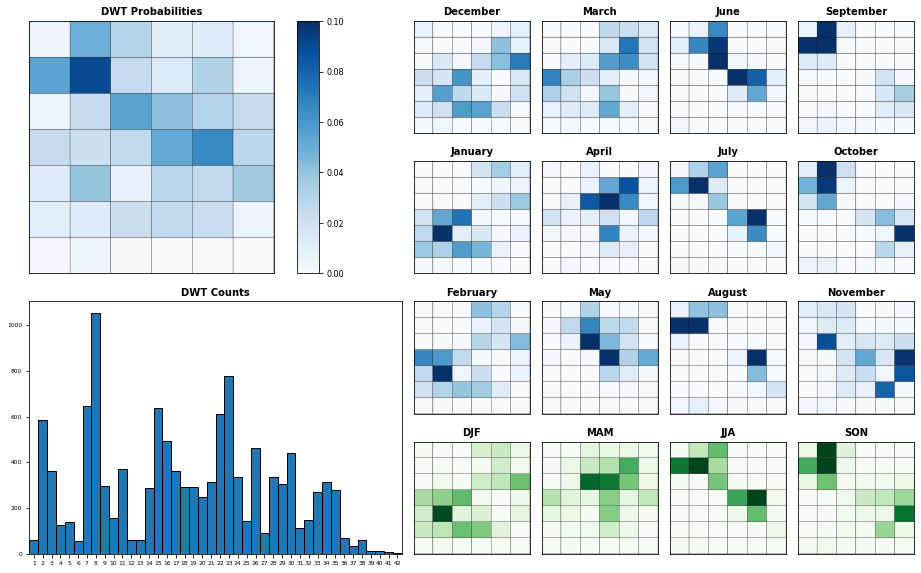

In [12]:
# Plot Historical DWTs probabilities (with TCs DWTs)

bmus_fit = KMA_fit.sorted_bmus_storms.values[:] + 1
dbmus_fit = KMA_fit.time.values[:]

Plot_DWTs_Probs(bmus_fit, dbmus_fit, alr_num_clusters);


In [ ]:
# Plot Simulated DWTs probabilities (with TCs DWTs)

bmus_sim = DWT_sim.isel(n_sim=0).evbmus_sims.values[:]
dbmus_sim = DWT_sim.time.values[:]

Plot_DWTs_Probs(bmus_sim, dbmus_sim, alr_num_clusters);


In [ ]:
# Plot AWTs/DWTs Probabilities 

# clusters to plot (no TCs)
n_clusters_AWT = 6
n_clusters_DWT = 42
n_sim = 0  # simulation to plot

# Plot AWTs/DWTs Probs - historical
AWT_hist, DWT_hist = db.Load_AWTs_DWTs_Plots_hist()
AWT_bmus = AWT_hist.bmus.values[:]
DWT_bmus = DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs Probabilities by AWTs - Historical'
);

# Plot AWTs/DWTs sim - simulated
AWT_sim, DWT_sim = db.Load_AWTs_DWTs_Plots_sim(n_sim=0)
AWT_bmus = AWT_sim.bmus.values[:]
DWT_bmus = DWT_sim.bmus.values[:]

Plot_Probs_WT_WT(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs Probabilities by AWTs - Simulation'
);
